# Testing & comparing reliability measures with a linear model (LSMC, LP, AMLS...)

## 1. Imports

In [1]:
import numpy as np 
import numpy.linalg as LA
import scipy.stats as stat
from time import time
from scipy.special import betainc
import matplotlib.pyplot as plt
from tqdm import tqdm
import cProfile,pstats
import tensorflow as tf
from dev.langevin_base import LangevinSMCBase
import dev.langevin_base as smc
#from sampling_tools import ImportanceSampling, ImportanceSplitting, ImportanceSplittingLp
from importlib import reload
import sampling_tools as s_t
reload(s_t)
from utils import project_ball, projected_langevin_kernel, uniform_ball_gen

ModuleNotFoundError: No module named 'langevin_smc'

In [13]:
def float_to_file_float(x):
    x=str(x).replace('.','_').replace(',','_')
    return x

In [14]:
tf.config.list_physical_devices()
profiling_logs= "/home/karim-tito/sampling-reliability-measure/logs/profiling"

## 2. Problem parameters

In [15]:
d = 1024
epsilon = 1
c = 0.6
h = 1-c
e_1 = np.array([1]+[0]*(d-1))
P_target = 0.5*betainc(0.5*(d+1),0.5,(2*epsilon*h-h**2)/(epsilon**2))
V_batch = lambda X: np.clip(c-X[:,0],a_min=0, a_max = np.inf)
gradV_batch = lambda X: -e_1[None]*(X[:,0]<c)[:,None] 
print(f"P_target:{P_target}")

P_target:9.633388200511323e-102


In [16]:
from utils import dichotomic_search
p_t=1e-15
p_target=lambda h: 0.5*betainc(0.5*(d+1),0.5,(2*epsilon*h-h**2)/(epsilon**2))
h,P_target = dichotomic_search(f=p_target,a=0,b=1,thresh=p_t )
c=1-h

## 2. Naive Monte Carlo

In [17]:
N_mc = 100_000
X = uniform_ball_gen(N_mc,epsilon,d)

In [18]:
P_est_MC = np.mean(X[:,0]>c)
error_MC = np.abs(P_target-P_est_MC)/P_target
print(f"Relative error of naive MC estimator :{error_MC}")

Relative error of naive MC estimator :1.0


In [19]:
P_est_MC, P_target

(0.0, 1.0000000000000385e-15)

## 2# Batched Monte Carlo

In [20]:
N_batch=int(1e5)
N_mc=int(1e6)
count=0
nb_batches= N_mc//N_batch
for b in tqdm(range(nb_batches)):
    X=uniform_ball_gen(N_batch,epsilon,d)
    count+=(X[:,0]>c).sum()
X_last=uniform_ball_gen(N_mc%N_batch,epsilon,d)
count+=(X_last[:,0]>c).sum()

P_est_MC_b=count/N_mc
P_est_MC,P_target

100%|██████████| 10/10 [00:29<00:00,  2.91s/it]


(0.0, 1.0000000000000385e-15)

## 3. Langevin Monte Carlo

In [21]:
prjct_epsilon = lambda X: project_ball(X, R=epsilon)
prjct_epsilon_langevin_kernel = lambda X, gradV, delta_t,beta: projected_langevin_kernel(X,gradV,delta_t,beta, projection=prjct_epsilon)


big_gen= lambda N: np.random.normal(size=(N,d+2))
norm_and_select= lambda X: (X/LA.norm(X, axis=1)[:,None])[:,:d] 
alt_uniform_gen_epsilon = lambda N: epsilon*norm_and_select(big_gen(N))

### Testing the basic Langevin method

In [22]:
N_lmc=100
rho=85

profiler = cProfile.Profile()
profiler.enable()
Langevin_est = LangevinSMCBase(alt_uniform_gen_epsilon , V=V_batch, gradV= gradV_batch,min_rate=0.4, N=1000, beta_0 = 0, rho=100, l_kernel = prjct_epsilon_langevin_kernel, alpha = 0.01, n_max=4000, T=1, verbose=0)
profiler.disable()
p_stats_lmc = pstats.Stats(profiler).sort_stats('tottime')
#stats.print_stats()
error_LMC = np.abs(P_target-Langevin_est)/P_target

print(f"Relative error of Langevin MC estimator :{error_LMC}, LMC estimation: {Langevin_est}")
print(f"True probability: {P_target}")

Relative error of Langevin MC estimator :1.5500579494519717, LMC estimation: 2.55005794945207e-15
True probability: 1.0000000000000385e-15


### Testing simple adaptive Langevin dynamics method 

In [31]:
profiler = cProfile.Profile()
profiler.enable()
Langevin_est = smc.SimpAdaptLangevinSMC(alt_uniform_gen_epsilon , V=V_batch, gradV= gradV_batch, N=100,l_kernel = prjct_epsilon_langevin_kernel, alpha = 0.025, n_max=2000, T=5, verbose=0)
profiler.disable()
p_stats_almc = pstats.Stats(profiler).sort_stats('tottime')
#stats.print_stats()
error_LMC = np.abs(P_target-Langevin_est)/P_target

print(f"Relative error of Simple adaptive Langevin MC estimator :{error_LMC}, Simp adaptive LMC estimation: {Langevin_est}")
print(f"True probability: {P_target}")

Relative error of Simple adaptive Langevin MC estimator :0.9099654049682019, Simp adaptive LMC estimation: 4.4999999978296645e-12
True probability: 4.998078789870014e-11


In [1]:
n_iter=10
times_lmc= []
rel_errors_lmc= []
estimates_lmc = []
n_iter
for i in range(n_iter):
    t=time()
    Langevin_est = LangevinSMCBase(alt_uniform_gen_epsilon , V=V_batch, gradV= gradV_batch,min_rate=0.40, N=40, beta_0 = 0, rho=90, l_kernel = prjct_epsilon_langevin_kernel, alpha = 0.025, n_max=2000, T=1, verbose=0)
    t=time()-t
    times_lmc.append(t)
    estimates_lmc.append(Langevin_est)
    error_LMC = (Langevin_est-P_target)/P_target
    rel_errors_lmc.append(error_LMC)

times_lmc=np.array(times_lmc)
rel_errors_lmc = np.array(rel_errors_lmc)
estimates_lmc = np.array(estimates_lmc)
plt.hist(times_lmc, bins=20)
print(rel_errors_lmc.max(),rel_errors_lmc.min())

NameError: name 'time' is not defined

In [11]:
n_iter=10
times_almc= []
rel_errors_almc= []
estimates_almc = []
n_iter
for i in range(n_iter):
    t=time()
    Langevin_est = smc.SimpAdaptLangevinSMC(alt_uniform_gen_epsilon , V=V_batch, gradV= gradV_batch, N=100,l_kernel = prjct_epsilon_langevin_kernel, alpha = 0.1, n_max=2000, T=1, verbose=0)
    t=time()-t
    times_almc.append(t)
    estimates_almc.append(Langevin_est)
    error_LMC = (Langevin_est-P_target)/P_target
    rel_errors_almc.append(error_LMC)

times_almc=np.array(times_almc)
rel_errors_almc = np.array(rel_errors_almc)
estimates_almc = np.array(estimates_almc)
plt.hist(times_almc, bins=10)
print(rel_errors_almc.max(),rel_errors_almc.min())

NameError: name 'alt_uniform_gen_epsilon' is not defined

In [115]:
rel_errors_lmc.max(),rel_errors_lmc.min()

(16.421073712585564, -0.6612419335555484)

In [43]:
import scipy.stats as stat

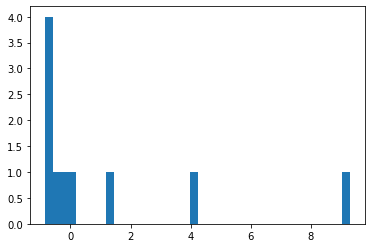

In [36]:
n,bins, patches=plt.hist(rel_errors_lmc, bins=40)

In [37]:
estimates_lmc.mean(), estimates_lmc.std(), P_target

(8.944472347459624e-23, 1.2940878216674538e-22, 4.196227315500506e-23)

In [38]:
((estimates_lmc-P_target)/P_target).mean()

1.131550956360135

### AMLS

In [5]:
x = np.random.normal(size = (64,d+1))

phi_batch_f = lambda x : stat.norm.cdf(x[:,0])
renorm_batch_l = lambda x: x[:,1:]/LA.norm(x[:,1:], axis=1)[:,None]
gaussian_gen_d = lambda N: np.random.normal(size = (N,d+1))
batch_uniform_transform = lambda x: renorm_batch_l(x)*phi_batch_f(x)[:,None]**(1./d)

alternative_gen = lambda N: np.random.normal(size=(N,d+2))
alternative_transform = lambda x: (x/LA.norm(x,axis=1)[:,None])[:d]
normal_kernel =  lambda x,s : (x + s*np.random.normal(size = x.shape))/np.sqrt(1+s**2) #normal law kernel, appliable to vectors 

h_V_batch = lambda x: -V_batch(batch_uniform_transform(x)).reshape((x.shape[0],1))
h_V_alt= lambda x: -V_batch(alternative_transform(x)).reshape((x.shape[0],1))

NameError: name 'np' is not defined

In [87]:
mls_est_alt = s_t.ImportanceSplitting(alternative_gen, normal_kernel,K=60, N=100,s=1,  h=h_V_alt, tau=0 , n_max=20000,clip_s=True , 
s_min= 8e-3, s_max =3)

Iter =  1  tau_j =  [-0.31445981] h_mean -0.30218816841641355  Calls =  100
Strength of kernel increased!
s=0.95
Iter =  2  tau_j =  [-0.29189659] h_mean -0.2797867442328237  Calls =  1300
Strength of kernel increased!
s=0.9025
Iter =  3  tau_j =  [-0.27451676] h_mean -0.26622575197456316  Calls =  2500
Strength of kernel increased!
s=0.8573749999999999
Iter =  4  tau_j =  [-0.26242681] h_mean -0.25489413870952  Calls =  3700
Strength of kernel increased!
s=0.8145062499999999
Iter =  5  tau_j =  [-0.2537629] h_mean -0.24733928608990266  Calls =  4900
Strength of kernel increased!
s=0.7737809374999999
Iter =  6  tau_j =  [-0.24539322] h_mean -0.23899918472814374  Calls =  6100
Strength of kernel increased!
s=0.7350918906249998
Iter =  7  tau_j =  [-0.23747385] h_mean -0.23277340281584852  Calls =  7300
Strength of kernel increased!
s=0.6983372960937497
Iter =  8  tau_j =  [-0.23104192] h_mean -0.22675667840626065  Calls =  8500
Strength of kernel increased!
s=0.6302494097246091
Iter =  

In [89]:
amls_profile_log= os.path.join(profiling_logs,'amls_linear_profile.txt')
cProfile.run("s_t.ImportanceSplitting(alternative_gen, normal_kernel,K=60, N=100,s=1,  h=h_V_alt, tau=0 , n_max=20000,clip_s=True , s_min= 8e-3, s_max =3,verbose=0)",
sort="tottime")

Strength of kernel increased!
s=0.95
Strength of kernel increased!
s=0.9025
Strength of kernel increased!
s=0.8573749999999999
Strength of kernel increased!
s=0.8145062499999999
Strength of kernel increased!
s=0.7737809374999999
Strength of kernel increased!
s=0.7350918906249998
Strength of kernel increased!
s=0.6983372960937497
Strength of kernel increased!
s=0.6634204312890623
Strength of kernel increased!
s=0.6302494097246091
Strength of kernel increased!
s=0.5987369392383786
Strength of kernel increased!
s=0.5688000922764596
Strength of kernel increased!
s=0.5403600876626365
Strength of kernel increased!
s=0.5133420832795047
Strength of kernel increased!
s=0.48767497911552943
Strength of kernel increased!
s=0.46329123015975293
Strength of kernel increased!
s=0.44012666865176525
Strength of kernel increased!
s=0.41812033521917696
Strength of kernel increased!
s=0.3972143184582181
Strength of kernel increased!
s=0.37735360253530714
Strength of kernel increased!
s=0.35848592240854177


In [ ]:
mls_est_alt[0]

2.0117032497289632e-22

In [ ]:
n_iter=10
times_mls= []
rel_errors_mls= []
estimates_mls = []
n_iter
for i in range(n_iter):
    t=time()
    mls_est_alt = s_t.ImportanceSplitting(alternative_gen, normal_kernel,K=80, N=100,s=0.5,  h=h_V_alt, tau=0 , n_max=20000,clip_s=True,s_min=1e-2,s_max=3)
    t=time()-t
    times_mls.append(t)
    estimates_mls.append(mls_est_alt[0])
    error_mls = (mls_est_alt[0]-P_target)/P_target
    rel_errors_mls.append(error_mls)

Iter =  1  tau_j =  [-0.32068401] h_mean -0.2958949860184299  Calls =  100
Strength of kernel increased!
s=0.475
Iter =  2  tau_j =  [-0.30675636] h_mean -0.2851286793715601  Calls =  700
Strength of kernel increased!
s=0.45125
Iter =  3  tau_j =  [-0.29322354] h_mean -0.2767273535524832  Calls =  1300
Strength of kernel increased!
s=0.42868749999999994
Iter =  4  tau_j =  [-0.28663712] h_mean -0.27014246554116056  Calls =  1900
Strength of kernel increased!
s=0.40725312499999994
Iter =  5  tau_j =  [-0.28023926] h_mean -0.26621557129123774  Calls =  2500
Strength of kernel increased!
s=0.38689046874999994
Iter =  6  tau_j =  [-0.27306916] h_mean -0.26102559879929416  Calls =  3100
Strength of kernel increased!
s=0.3675459453124999
Iter =  7  tau_j =  [-0.2688208] h_mean -0.2571375588439527  Calls =  3700
Strength of kernel increased!
s=0.34916864804687486
Iter =  8  tau_j =  [-0.26528493] h_mean -0.2539231381907485  Calls =  4300
Strength of kernel increased!
s=0.3317102156445311
Iter

In [ ]:
mls_est = ImportanceSplitting(gaussian_gen_d, normal_kernel,K=80, N=100,s=0.1,  h=h_V_batch, tau=0 , n_max=20000)

Iter =  1  tau_j =  [-0.31943145] h_mean -0.2979281168388906  Calls =  100
Strength of kernel increased!
s=0.10001
Iter =  2  tau_j =  [-0.30789349] h_mean -0.28668195392188606  Calls =  700
Strength of kernel increased!
s=0.100020001
Iter =  3  tau_j =  [-0.29873926] h_mean -0.27970696958273533  Calls =  1300
Strength of kernel increased!
s=0.1000300030001
Iter =  4  tau_j =  [-0.28909353] h_mean -0.27380434649211116  Calls =  1900
Strength of kernel increased!
s=0.1000400060004
Iter =  5  tau_j =  [-0.28220845] h_mean -0.26929386555337426  Calls =  2500
Strength of kernel increased!
s=0.10005001000100004
Iter =  6  tau_j =  [-0.27503572] h_mean -0.26554481118058376  Calls =  3100
Strength of kernel increased!
s=0.10006001500200014
Iter =  7  tau_j =  [-0.27080403] h_mean -0.2621483709433592  Calls =  3700
Strength of kernel increased!
s=0.10007002100350033
Iter =  8  tau_j =  [-0.26753821] h_mean -0.2591843725434128  Calls =  4300
Strength of kernel increased!
s=0.10008002800560069
I

In [ ]:
MLS_est= mls_est[0]
error_LMC = np.abs(P_target-MLS_est)/P_target
print(f"Relative error of AMLS estimator :{error_LMC}, \n MLS estimation: {MLS_est}", )

Relative error of AMLS estimator :0.10263493745242036, 
 MLS estimation: 4.626906843563038e-23


In [ ]:
times_mls=np.array(times_mls)
rel_errors_mls = np.array(rel_errors_mls)
estimates_mls = np.array(estimates_mls)

In [ ]:
rel_errors_mls

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

(array([9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1.]),
 <BarContainer object of 16 artists>)

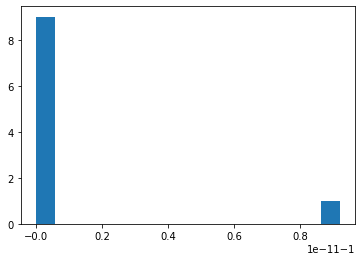

In [ ]:
plt.hist(rel_errors_mls, bins=16)

### Last particle

In [ ]:
def h_V(X):
    if len(X.shape)==2:
        scores= h_V_batch(X).reshape(-1)
    else:
        scores= h_V_batch(X.reshape(1,-1)).reshape(-1)

    return scores

In [ ]:
def h_V_a(X):
    if len(X.shape)==2:
        scores= h_V_alt(X).reshape(-1)
    else:
        scores= h_V_alt(X.reshape(1,-1)).reshape(-1)

    return scores

In [ ]:
lp_est = ImportanceSplittingLp(alternative_gen, normal_kernel, N=100,s=1,  h=h_V_a, tau=0 , n_max=20000, T=50, verbose=1)

In [ ]:
LP_est= lp_est[0]
error_LMC = np.abs(P_target-LP_est)/P_target
print(f"Relative error of AMLS estimator :{error_LMC}, \n LP estimation: {LP_est}", )

Relative error of AMLS estimator :237.3093013827171, 
 LP estimation: 1e-20
